In [1]:
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import keras
import sys
import pandas as pd
import sklearn as sk
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices("GPU")) > 0
print(tf.config.list_physical_devices("GPU"))
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.19.0
Keras Version: 3.10.0

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas 2.2.2
Scikit-Learn 1.6.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


In [2]:
# SEMILLA
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Parámetros
INPUT_FORMAT = (224, 224, 3)
BATCH_SIZE = 8 #trabajar con valores grandes - 16 si tiene poco recurso - aleatorio en cada epoca
EPOCHS = 64
INIT_LR = 1e-4 # se va reduciendo poco a poco o -3 o -2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
path = "/content/drive/MyDrive/Semestre/IA/Dataset/processed_dataset"
os.listdir(path)

['train', 'val', 'test']

In [6]:
preprocess_fn = tf.keras.applications.vgg16.preprocess_input

# Rutas
ruta_entrenamiento = f"{path}/train"
ruta_validacion = f"{path}/val"
ruta_test = f"{path}/test"


# Generadores
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_fn,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.20,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest",
)
datagen_valid = ImageDataGenerator(
    preprocessing_function=preprocess_fn,
)  # ANTES APLIQUE RESCALE
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_fn,
)

generador_entrenamiento = datagen.flow_from_directory(
    ruta_entrenamiento,
    target_size=INPUT_FORMAT[:2],
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
)

generador_validacion = datagen_valid.flow_from_directory(
    ruta_validacion,
    target_size=INPUT_FORMAT[:2],
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical",
)

generador_test = datagen_test.flow_from_directory(
    ruta_test,
    target_size=INPUT_FORMAT[:2],
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical",
)

Found 2808 images belonging to 6 classes.
Found 357 images belonging to 6 classes.
Found 358 images belonging to 6 classes.


In [7]:
steps = len(generador_entrenamiento.filepaths) // generador_entrenamiento.batch_size
steps

351

In [8]:
learning_rate = INIT_LR

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D


# Construccion del modelo
# --------------------------------------------------------------------------
def model_init(learning_rate, dropout_rate, l2_reg, is_finetune=True):
    if is_finetune:
        weigths = "imagenet"
    else:
        weigths = None
    base_model = VGG16(weights=weigths, include_top=False, input_shape=INPUT_FORMAT)

    # for layer in base_model.layers:
    #     layer.trainable = False

    # aplicar fine tuning a partir de la capa bloque5_conv1
    #revisar
    base_model.trainable = False  # ✅ congelar TODO el backbone


    entrada = layers.Input(shape=INPUT_FORMAT)
    x = base_model(entrada, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = layers.Dense(
        256, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)
    )(x) #revisar cuantas capas usa en esas 256 neuronas
    x = layers.Dropout(dropout_rate)(x)
    salida = layers.Dense(6, activation="softmax")(x) # Changed from 4 to 6

    model = Model(inputs=entrada, outputs=salida)
    optimizador = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizador, metrics=["accuracy"]
    )
    model.summary()
    return model

## optimizador bayesiano (aun no usarlo)

In [10]:
# from bayes_opt import BayesianOptimization
# from sklearn.model_selection import train_test_split
# import numpy as np


# # 1. Definir función objetivo a optimizar
# def optimize_model(lr, dropout_rate, l2_reg):
#     # Convertir parámetros
#     lr = 10**lr  # Usar escala logarítmica
#     l2_reg = 10**l2_reg

#     # Construir modelo con hiperparámetros actuales
#     modelo = model_init(learning_rate=lr, dropout_rate=dropout_rate, l2_reg=l2_reg)

#     # Entrenamiento reducido para evaluación rápida
#     history = modelo.fit(
#         generador_entrenamiento,
#         validation_data=generador_validacion,
#         epochs=3,
#         verbose=1,
#     )

#     # Retornar el mejor valor de val_accuracy
#     return np.max(history.history["val_accuracy"])


# # 2. Definir espacio de búsqueda
# pbounds = {
#     "lr": (-5, -2),  # 10^-5 a 10^-3
#     "dropout_rate": (0.7, 0.9),
#     "l2_reg": (-5, -2),  # 10^-5 a 10^-2
# }

# # 3. Crear optimizador bayesiano
# optimizer = BayesianOptimization(
#     f=optimize_model, pbounds=pbounds, random_state=42, verbose=1
# )

# # 4. Ejecutar optimización
# optimizer.maximize(
#     init_points=2,  # Exploración inicial aleatoria
#     n_iter=10,  # Iteraciones bayesianas
# )

In [11]:
# optimizer.max["params"]

In [12]:
# Obtener mejores parámetros
# best_params = optimizer.max["params"]

In [13]:
# Configuración de callbacks
import os

path_models = "./models/VGG16/"
os.makedirs(path_models, exist_ok=True)
arch = "VGG16"

## entrenamiento

In [14]:
model = model_init(learning_rate, 0.5, 1e-2, is_finetune=False)
#si aumentas el valor de regularizador lo haces mas simple
#analizar:
#ver la arquitectura del modelo
#ver los hiperparametros, dropout revisar las graficas de despues del entrenamiento. max aumentar a 0.6

#que capas poner el dropout preguntar gpt

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,606 (56.65 MB)

 Trainable params: 133,894 (523.02 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [15]:
# # Ruta donde se guardará el archivo (ej: 'C:/Users/tu_usuario/proyecto/resultados/hiperparametros.txt')
# ruta_archivo = path_models + "hiperparametros.txt"  # ¡Cambia esto!

# # Asegurarse de que la carpeta exista (si no, la crea)
# os.makedirs(os.path.dirname(ruta_archivo), exist_ok=True)

# # Guardar en formato legible (clave = valor)
# with open(ruta_archivo, "w") as f:
#     for key, value in best_params.items():
#         f.write(f"{key} = {value}\n")

# print(f"¡Hiperparámetros guardados en: {ruta_archivo}!")

In [16]:
checkpoint = ModelCheckpoint(
    path_models + "model_vgg16.weights.h5",
    monitor="val_loss",  # <-- Guarda el mejor modelo basado en val_loss (más estable que val_accuracy)
    verbose=1,
    save_best_only=True,  # guarda cuando haya mejoras
    save_weights_only=True,
    mode="min",  # estaba en auto
)

early = EarlyStopping(
    monitor="val_accuracy", #puede cambiar a value loss
    min_delta=0.001,
    patience=10,  # <-- Detén el entrenamiento cuando val_accuracy no mejore en 10 EPOCHS
    verbose=1,
    restore_best_weights=True,
    mode="max",
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitorear pérdida de validación
    mode="min",  # Reducir LR cuando val_loss deje de disminuir
    factor=0.5,  # Reducción moderada del LR
    patience=5,  # Esperar 5 EPOCHS sin mejora
    verbose=1,
    min_lr=1e-6,  # LR mínimo permitido+
)

# Añadir a los callbacks
callbacks = [checkpoint, reduce_lr, early]  # <-- Añadido

In [17]:
historia_1 = model.fit(
    generador_entrenamiento,
    # steps_per_epoch=generador_entrenamiento.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=generador_validacion,
    # validation_steps=generador_validacion.samples // BATCH_SIZE,
    callbacks=callbacks,
    # class_weight=class_weights  # <-- Añadir esto
)

#ir viendo el validation acc: alto y el loss tiene que ser bajo

#disminuir el learning rate si hay muy bajo el acc o aumentar el dropout



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/64
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2517 - loss: 5.0780
Epoch 1: val_loss improved from inf to 4.42397, saving model to ./models/VGG16/model_vgg16.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 1982s 6s/step - accuracy: 0.2518 - loss: 5.0772 - val_accuracy: 0.4370 - val_loss: 4.4240 - learning_rate: 1.0000e-04
Epoch 2/64
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3814 - loss: 4.2308
Epoch 2: val_loss improved from 4.42397 to 3.75352, saving model to ./models/VGG16/model_vgg16.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.3814 - loss: 4.2304 - val_accuracy: 0.5266 - val_loss: 3.7535 - learning_rate: 1.0000e-04
Epoch 3/64
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4532 - loss: 3.7260
Epoch 3: val_loss improved from 3.75352 to 3.37140, saving model to ./models/VGG16/model_vgg16.weights.h5
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.4532 - loss: 3.7258 - val_accuracy: 0.5350 - val_loss: 3.3714 - learning

In [18]:
# 2) descongelar block5
base_model = model.get_layer("vgg16")  # el nombre suele ser "vgg16"
for layer in base_model.layers:
    layer.trainable = layer.name.startswith("block5")

# 3) recompilar con LR pequeño (MUY importante)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

historia = model.fit(
    generador_entrenamiento,
    epochs=EPOCHS,          # ej: 10 a 20
    validation_data=generador_validacion,
    callbacks=callbacks
)

Epoch 1/64
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5388 - loss: 1.5501
Epoch 1: val_loss did not improve from 1.14581
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 213ms/step - accuracy: 0.5388 - loss: 1.5500 - val_accuracy: 0.3754 - val_loss: 2.5683 - learning_rate: 1.0000e-05
Epoch 2/64
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5996 - loss: 1.4116
Epoch 2: val_loss did not improve from 1.14581
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 210ms/step - accuracy: 0.5995 - loss: 1.4116 - val_accuracy: 0.3754 - val_loss: 3.1393 - learning_rate: 1.0000e-05
Epoch 3/64
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5931 - loss: 1.4175
Epoch 3: val_loss did not improve from 1.14581
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 208ms/step - accuracy: 0.5931 - loss: 1.4174 - val_accuracy: 0.4734 - val_loss: 1.9079 - learning_rate: 1.0000e-05
Epoch 4/64
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6514 - loss: 1.2804
Epoch 4: val_loss did not improve from 1.14581
351/351 ━━━━━━━━

In [19]:
model.save(path_models + arch + "/model_vgg16.h5")

Learning rate actual: 9.999999974752427e-07


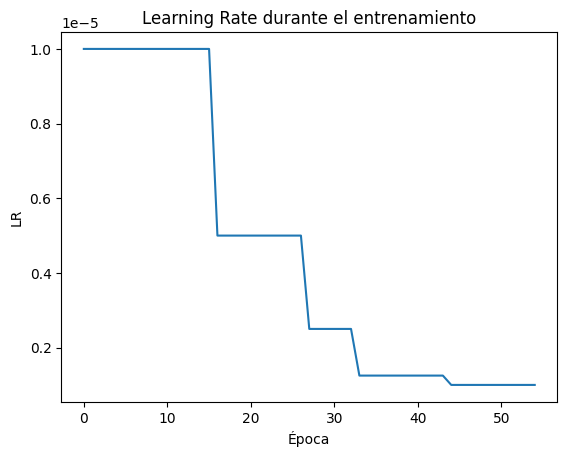

In [20]:
current_lr = model.optimizer.learning_rate.numpy()
print(f"Learning rate actual: {current_lr}")

# Graficar el learning rate a lo largo de las épocas
plt.plot(historia.history["learning_rate"])
plt.title("Learning Rate durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("LR")
plt.savefig(path_models + "VGG16_lr_plot.png")
plt.show()

In [21]:
model.save(path_models + arch + "/model_VGG16_arch.h5")

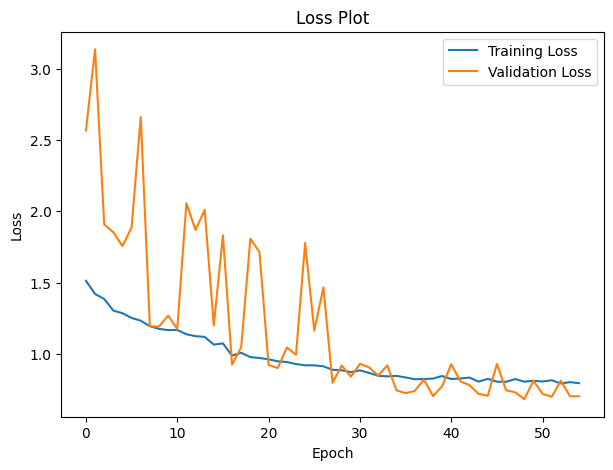

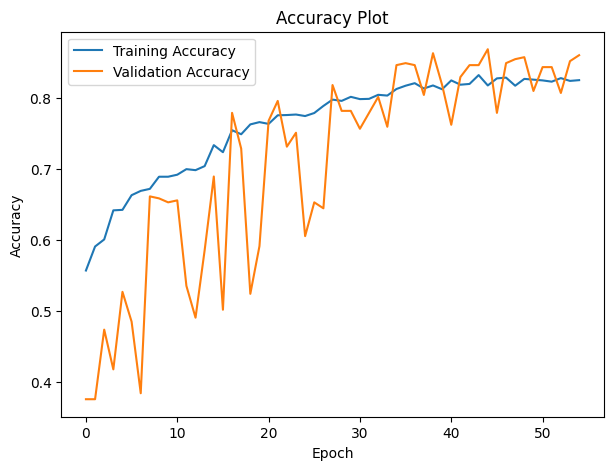

In [22]:
# Gráfico de Pérdida
plt.figure(figsize=(7, 5))
plt.plot(historia.history["loss"], label="Training Loss")
plt.plot(historia.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path_models + "VGG16_loss_plot.png")  # Guarda el gráfico en loss_plot.png
plt.show()

# Gráfico de Precisión
plt.figure(figsize=(7, 5))
plt.plot(historia.history["accuracy"], label="Training Accuracy")
plt.plot(historia.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(
    path_models + "VGG16_accuracy_plot.png"
)  # Guarda el gráfico en accuracy_plot.png
plt.show()

In [23]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Evaluación sobre el set de prueba
y_pred = model.predict(generador_test, verbose=1)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = generador_test.classes

# Calcular métricas
cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

categories = [
    "Alphids",
    "Army worm",
    "Bacterial Blight",
    "Healthy",
    "Powdery Mildew",
    "Target spot"
]

# Crear la gráfica de la matriz de confusión
sns.set(font_scale=1.4)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap="Pastel1_r",
    xticklabels=categories,
    yticklabels=categories,
)
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig(
    path_models + "VGG16_confusion_matrix.png"
)  # Guarda la imagen en un archivo PNG
plt.close()  # Cierra la figura

class_counts = cm.sum(axis=1)  # número total de instancias reales por clase
diag = np.diag(cm)  # verdaderos positivos por clase
class_accuracy = diag / class_counts

# Tabla en pandas
df = pd.DataFrame(
    {
        "Clase": categories,
        "Accuracy": class_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }
)

# Imprimir en pantalla (opcional)
print(f"Accuracy: {accuracy}")
print(df)
print("Average Precision:", df["Precision"].mean())
print("Average Recall:", df["Recall"].mean())
print("Average F1-Score:", df["F1-Score"].mean())

# Guardar las métricas en un archivo de texto
with open(path_models + "VGG16_metrics.txt", "w") as f:
    f.write(f"Accuracy: {accuracy}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(cm))
    f.write("\n\nMetrics Table:\n")
    f.write(df.to_string(index=False))
    f.write("\n\n")
    f.write(f"Average Precision: {df['Precision'].mean()}\n")
    f.write(f"Average Recall: {df['Recall'].mean()}\n")
    f.write(f"Average F1-Score: {df['F1-Score'].mean()}\n")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 253s 6s/step
Accuracy: 0.8547486033519553
              Clase  Accuracy  Precision    Recall  F1-Score
0           Alphids  0.866667   0.825397  0.866667  0.845528
1         Army worm  0.966667   0.966667  0.966667  0.966667
2  Bacterial Blight  0.700000   0.875000  0.700000  0.777778
3           Healthy  0.983051   0.865672  0.983051  0.920635
4    Powdery Mildew  0.966667   0.852941  0.966667  0.906250
5       Target spot  0.644068   0.730769  0.644068  0.684685
Average Precision: 0.852740923515726
Average Recall: 0.8545197740112994
Average F1-Score: 0.8502570841747671


In [24]:
import shutil
import os

source_folder = './models/VGG16'
destination_drive_folder = '/content/drive/MyDrive/colab_models_backup/VGG16/changed_prepro'

# Create the destination folder in Drive if it doesn't exist
os.makedirs(destination_drive_folder, exist_ok=True)

# Copy the entire 'models' folder to Google Drive
try:
    shutil.copytree(source_folder, destination_drive_folder, dirs_exist_ok=True)
    print(f"Successfully copied '{source_folder}' to '{destination_drive_folder}'")
except Exception as e:
    print(f"Error copying folder: {e}")

Successfully copied './models/VGG16' to '/content/drive/MyDrive/colab_models_backup/VGG16'
